# Classification test

In [66]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [84]:
df = pd.read_csv("data/BTCUSDT-hour-target-features.csv")
# df1 = pd.read_csv("data/modelv1_training_data.csv")
# dfd = pd.read_csv("data/classification_test.csv")

In [85]:
df.head(3)

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,...,volatility_dc_wband_10,volatility_pband_50,volatility_wband_20,volatility_ui_30,volume_cmf_50,volume_cmf_50_rate_200,volume_eom_amplified,volume_fi_amplified,volume_mfi_50,volume_nvi_o_close_rate_50
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,...,NaN,0.636138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,...,NaN,0.635331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,...,NaN,0.660209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# a = df1["sma_close_50"][500:1000] == df["sma_50_o_close"][500:1000]
# a.value_counts()

In [87]:
# df1["sma_close_50"][500:1000], df["sma_50_o_close"][500:1000]

In [88]:
indicators = list(df.columns)[13:]
indicators.append("target")

In [89]:
indicators = ['volatility_dc_pband_50',
 'mom_rsi_30',
 'volatility_dc_wband_10',
 'mom_ppo_10_signal_log',
 'trend_cci_70',
 'trend_arn_50',
 'mom_ppo_30_hist',
 'trend_macd_12_signal_log',
 'mom_sr_9_signal',
 'volume_cmf_50_rate_200',
 'volume_fi_amplified',
 'trend_dpo_100_log',
 'target']

In [90]:
d = df.copy()
d.dropna(inplace=True)
close = d["close"][29000:]

d = d[list(indicators)].copy().astype(np.float32)

X = d.drop(["target", "close"], axis=1, errors="ignore")[:29000]
y = d["target"][:29000]

X_ft = d.drop(["target", "close"], axis=1, errors="ignore")[29000:]
y_ft = d["target"][29000:]

In [91]:
# X_ft_c = X_ft.copy()
# X_ft_c["close"] = close
# X_ft_c.to_csv("data/modelv1.1_testing.csv", index=False)

In [92]:
# X_ft.info()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [94]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Precision bug documentation

- Not assigning 

Text(-1.5, 0.5, 'Predicted label')

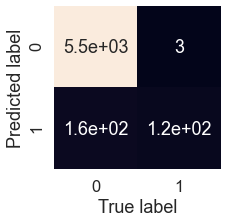

In [95]:
y_preds = model.predict(X_test)	

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True,
                 cbar=False)
plt.xlabel("True label")
plt.ylabel("Predicted label")

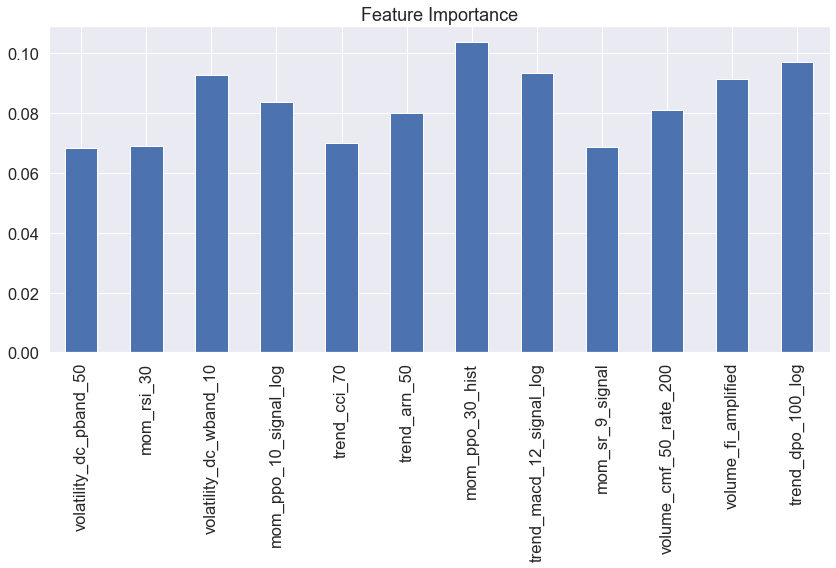

In [96]:
feature_dict = dict(zip(X_train.columns, list(model.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(14, 6));

In [82]:
d = {}
d["precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='precision'))
d

{'precision': 0.3536724613509526}

In [525]:
# d["recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='recall'))
# d

In [526]:
# d["f1"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))
# d

{'precision': 0.11151388927543224, 'f1': 0.08223445027482033}

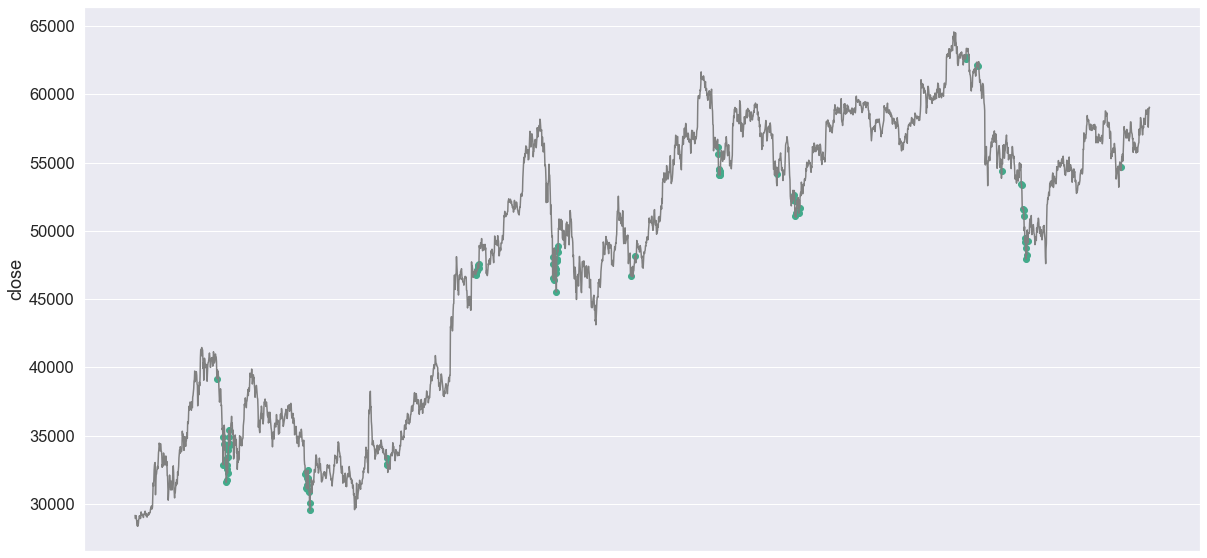

In [97]:
results = model.predict(X_ft)
scatter_results = list(map(lambda x, c: c if x == 1 else None, results, close))

s_correct = list(map(lambda x, t, c: c if x == 1 and t == 1 else None, results, y_ft, close))
s_wrong = list(map(lambda x, t, c: c if x == 1 and t == 0 else None, results, y_ft, close))
s_missed = list(map(lambda x, t, c: c if x == 0 and t == 1 else None, results, y_ft, close))

fig,ax = plt.subplots(figsize=(20, 10))

rows = len(close)
ax.scatter(range(rows), 
            scatter_results,
            color="#43aa8b")


# ax.scatter(range(rows), 
#             s_missed,
#         color="#f9c74f")

# ax.scatter(range(rows), 
#             s_correct,
#         color="#43aa8b")

# ax.scatter(range(rows), 
#             s_wrong,
#         color="#f94144")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(range(rows),
        close,
        color="gray")

ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

## Documentation of scores
| Modules (in order) | Precision (cv=5) E=error| F1 | TP:FP (TP/FP) | Notes |
| --- | :---: | :---: | :---: | --- |
| ` ` `sma` ` ` `volatility` `volume` | E:0. | 0. | 180/97 | |
| `momentum` `sma` `trend-` `volatility` `volume` | E:0. | 0. |  | |



| `momentum` `sma` `trend-` `volatility` `volume` | E:0. | 0. |  | |



In [48]:
from joblib import dump, load

In [49]:
dump(model, 'models/model_v1.1.joblib') 

['models/model_v1.1.joblib']